## T-SNE 2D-visualization of Data Distributions

Images are randomly picked from given datasets, which will be embedded into 2d-space for visualization.

In [44]:
import os
import cv2

root = '../data'
parent_dirs = ['SDUMLA', 'MMCBNU', 'FVUSM', 'HKPU-FV', 'UTFVP']
# parent_dirs = ['UTFVP']
sample_num = 400
child_dirs = ['roi', 'clahe', 'seg']
titles = ['Raw', 'Enhanced', 'Segmented']

To generate enhanced data first using *clahe equalizzation* and *gamma adjustment*.

In [3]:
# from tqdm import tqdm
# from utils.pre_process import pre_processing

# for p_dir in parent_dirs:
#     save_dir = os.path.join(root, p_dir, 'clahe')
#     os.makedirs(save_dir, exist_ok=True)
    
#     ps = os.path.join(root, p_dir, 'roi')
#     im_list = os.listdir(ps)
#     for im_path in tqdm(im_list, desc=p_dir):
#         im = cv2.imread(ps+f'/{im_path}')
#         im_processed = pre_processing(im)
#         cv2.imwrite(save_dir+f'/{im_path}', im_processed*255)

### a. Preprocessing data list

In [45]:
import random
import numpy as np
import sklearn
from tqdm import tqdm
from sklearn.manifold import TSNE 
from sklearn.datasets import load_digits # For the UCI ML handwritten digits dataset
from utils.draw import plot_tsne
import matplotlib
%matplotlib inline

lists = []
labels_list = []
for c_dir in tqdm(child_dirs):
    file_list = []
    labels = []
    for ind, p_dir in enumerate(parent_dirs):
        path = os.path.join(root, p_dir, c_dir)
        files = [os.path.join(path, i) for i in os.listdir(path)]
        random.shuffle(files)
        files = files[:sample_num]
        file_list += files
        labels += list((np.ones(len(files)) * (ind)).astype(int))
    lists.append(file_list)

100%|██████████| 3/3 [00:00<00:00, 10.34it/s]


### b. Embedding finger-vein images to 2d-space

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=128)

image_type = '.bmp'
target_size = [30, 75] # height, width
arr_list = []
trim = 8 # To alleviate the impact of image edge
for file_list, title in zip(lists, titles):
    arrs = []
    for file in tqdm(file_list, desc=title):
        im = cv2.imread(file, 0)
#         print(file)
        # trim image margins
        im[:trim, :] = 0; im[:, :trim] = 0
        im[:trim, :] = 0; im[:, :trim] = 0
        im[-trim:, :] = 0; im[:, -trim:] = 0
        im = cv2.resize(im, (target_size[1], target_size[0]))
        im = np.reshape(im, -1)
        arrs.append(im)
    im_array = pca.fit_transform(arrs)
    arr_list.append(np.array(im_array))

Segmented: 100%|██████████| 2000/2000 [00:00<00:00, 6113.74it/s]


In [50]:
from sklearn.manifold import TSNE

# need to ensure the [arr_list] and [labels] are consistent before T-SNE fitting
# otherwise the T-SNE cluster plot might be incorrect
embeddings = []
for arrs in tqdm(arr_list):
    X = arrs
    tmp = TSNE(perplexity=25).fit_transform(X)
    embeddings.append(tmp)
a = np.array(embeddings)
np.save('TSNE_embeddings.npy', a)
#     print('Done')

100%|██████████| 3/3 [00:36<00:00, 12.06s/it]


### c. Visualize results

In [57]:
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import warnings
warnings.filterwarnings("ignore")

#Play around with varying the parameters like perplexity, random_state to get different plots
def plot_tsne(ax, x, colors, title=None, annotate=True):
    palette = np.array(sb.color_palette("hls", 8))  #Choosing color palette 
    # Add the labels for each digit.
    txts = []
    for i in range(len(parent_dirs)):
        start_index = i*sample_num
        end_index = ((i+1)*sample_num)
#         print(start_index, end_index)
        sc = ax.scatter(x[start_index:end_index, 0], x[start_index:end_index, 1], 
                        lw=0, s=10, alpha=0.5, c=palette[colors.astype(np.int)[start_index:end_index]])
        ax.scatter([], [], c=palette[colors.astype(np.int)[start_index]], label=parent_dirs[i])
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        if annotate:
            txt = ax.text(xtext, ytext, db[i], fontsize=20)
            txt.set_path_effects([pe.Stroke(linewidth=5, foreground="w"), pe.Normal()])
            txts.append(txt)
    if title is not None:
        ax.set_title(title, fontsize=14)
    return ax, txts

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

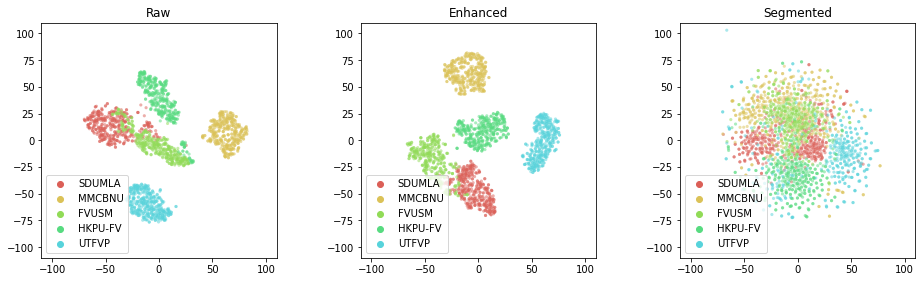

In [52]:
scatter_range = 110
f = plt.figure(figsize=(14, 18))
for ind, embedding in enumerate(embeddings):
    # Create a scatter plot.
    ax = plt.subplot(1, len(embeddings), ind+1, aspect='equal')
    plot_tsne(ax, embedding, np.array(labels), title=titles[ind], annotate=False)
#     ax.set_title(names[ind])
#     ax.set_aspect('equal')
    ax.set_ylim([-scatter_range, scatter_range])
    ax.set_xlim([-scatter_range, scatter_range])
    ax.legend(loc=3)
#     ax.legend(parent_dirs)
f.tight_layout(pad=5.0)
f.savefig(f'TSNE.pdf', bbox_inches='tight', dpi=300)

### d. Calculate 2d KL divergence

In [65]:
from utils.kl import KLdivergence_2d
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

distance_dict = {}
mean_distance = []
distance_map = {}
    
for embedding, title in zip(embeddings, titles):
    total_len = embedding.shape[0]
    distance_dict[title] = []
    distance_map[title] = np.zeros((len(parent_dirs), len(parent_dirs)))
    print(f'（{title}）: ')
    for ind, arr1_name in enumerate(parent_dirs[:-1]):
        indj = ind + 1
        for arr2_name in parent_dirs[indj:]:
            arr1 = embedding[(ind)*sample_num:(ind+1)*sample_num, :]
            arr2 = embedding[(indj)*sample_num:(indj+1)*sample_num, :]
            distance1 = KLdivergence(arr1, arr2)
            distance2 = KLdivergence(arr2, arr1)
    #         print(arr1.shape, arr2.shape)
    #         distance_dict[title].append([f'{arr1_name}, {arr2_name}', distance])
            distance_map[title][ind, indj] = distance1
            distance_map[title][indj, ind] = distance2
            distance_dict[title].append((distance1+distance2)/2)
            print(f'{arr1_name}, {arr2_name} ', distance1, distance2)
            indj += 1
            
    mean = sum(distance_dict[title]) / len(distance_dict[title])
    mean_distance.append(mean)
    print('Average: ', mean)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
（Raw）: 
SDUMLA, MMCBNU  10.6715527322016 9.319172467405892
SDUMLA, FVUSM  5.701115304281179 5.16330279792035
SDUMLA, HKPU-FV  8.995881957413925 7.2719305310727185
SDUMLA, UTFVP  10.016967948910494 9.440482880825426
MMCBNU, FVUSM  9.517814911977803 9.154145238995246
MMCBNU, HKPU-FV  9.224124940995384 9.347761123548015
MMCBNU, UTFVP  10.745966641967478 10.12656965784762
FVUSM, HKPU-FV  6.898675015341575 7.440821939102874
FVUSM, UTFVP  8.928516846878653 8.846272505006704
HKPU-FV, UTFVP  10.32256980556474 9.38116534706669
Average:  8.825740529716217
（Enhanced）: 
SDUMLA, MMCBNU  10.36338084146172 11.01920801496863
SDUMLA, FVUSM  5.802304055216052 7.000464064050468
SDUMLA, HKPU-FV  8.500971731701641 8.569172189235356
SDUMLA, UTFVP  9.379063625632341 9.950307424452804
MMCBNU, FVUSM  10.358557032054604 10.323875150992283
MMCBNU, HKPU-FV  9.61100098551979 8.937785083173326
MMCBNU, UTFVP  10.879580422512257 1

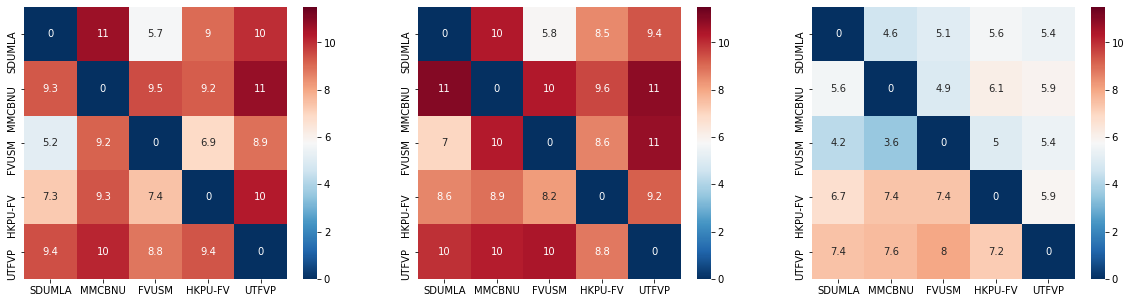

In [54]:
import pandas as pd
import seaborn as sns

vmax = 11.5
plt.figure(figsize=(20, 5))
for ind, title in enumerate(titles):
    plt.subplot(1, 3, ind+1)
    a = pd.DataFrame(distance_map[title])
    a.columns = parent_dirs
    a.index = parent_dirs
    sns.heatmap(data=a, annot=True, vmin=0, vmax=vmax, cmap="RdBu_r")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

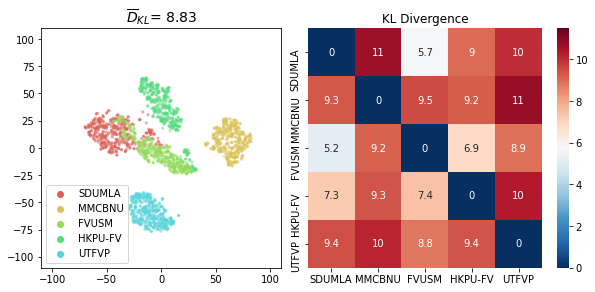

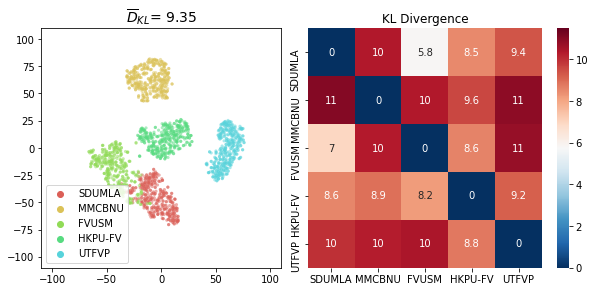

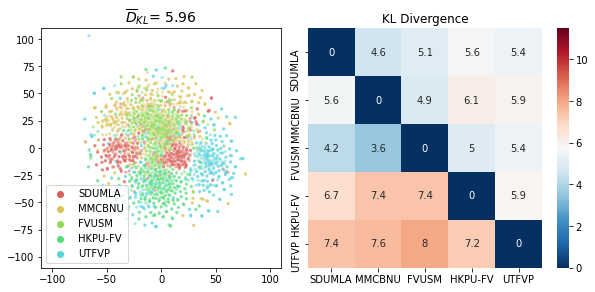

In [67]:
for ind, embedding in enumerate(embeddings):
#     f = plt.figure(figsize = (14, 18))
#     f = plt.figure(figsize = (5, 6))
    f = plt.figure(figsize = (10, 5))
    # Create a scatter plot.
#     ax = plt.subplot(1, len(embeddings), ind+1, aspect='equal')
    ax = plt.subplot(121, aspect = 'equal')
    plot_tsne(ax, embedding, np.array(labels), title=r'$\overline{D}_{KL}$'+f'= {round(mean_distance[ind], 2)}', annotate=False)
#     ax.set_title(names[ind])
#     ax.set_aspect('equal')
    ax.set_ylim([-scatter_range, scatter_range])
    ax.set_xlim([-scatter_range, scatter_range])
    ax.legend(loc=3)
    f.tight_layout(pad = 5.0)
    
    plt.subplot(122)
    a = pd.DataFrame(distance_map[titles[ind]])
    a.columns = parent_dirs
    a.index = parent_dirs
    sns.heatmap(data=a, annot=True, vmin=0, vmax=vmax, cmap="RdBu_r")
    plt.title('KL Divergence')
    plt.xticks(rotation=0)
    
    plt.subplots_adjust(wspace = 0, hspace = 0)
    f.savefig(f'TSNE_with_KL_{titles[ind]}.pdf', bbox_inches='tight', dpi=300)